In [63]:
import pandas as pd
import spacy
nlp = spacy.load("en_core_web_sm")
from collections import Counter
# nlp.max_length = 1850000
import seaborn as sns
import matplotlib.pyplot as plt
import gensim
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')
from textblob import TextBlob
from sklearn.pipeline import make_pipeline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df = pd.read_csv("/content/privacy_data_analysis.csv")

In [ ]:
df.info()

## **Pattern Matching**

In [ ]:
df.Q19[0]

In [ ]:
all_text = df.Q19.str.cat(sep = ' ')
doc = nlp(all_text)

In [ ]:
words = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct] 
word_freq = Counter(words) 
word_freq.most_common(30)

In [ ]:
from spacy.matcher import Matcher 
matcher = Matcher(nlp.vocab) 
pattern = [{'POS':'ADJ'}, {'POS':'NOUN'}] 
matcher.add('ADJ_PHRASE', [pattern]) 
matches = matcher(doc, as_spans=True) 
phrases = [] 
for span in matches:
    phrases.append(span.text.lower())
    phrase_freq = Counter(phrases)
phrase_freq.most_common(30)

In [ ]:
feel_adj = []
matcher = Matcher(nlp.vocab)
pattern = [{'LOWER' : {'IN' : ['i', 'we']}}, {'OP': '?'}, 
  {'LOWER': {'IN' : ['feel', 'am', "'m", 'are', "'re", "found"]}}, 
  {'OP': '?'}, {'OP': '?'}, {'POS':'ADJ'}]
matcher.add("FeelAdj", [pattern]) 
matches = matcher(doc, as_spans=True) 
for span in matches:
    feel_adj.extend([token.lemma_ for token in span if token.pos_ == 'ADJ'])
Counter(feel_adj)

## **Privacy Questions Analysis**

QUESTION 24: I find that device invades my privacy if used **during the class**

In [ ]:
df.Q24.value_counts()

In [ ]:
df.groupby('Q24').count()["Q25"]

QUESTION 46: I find that device invades my privacy if used during **out of the class discussion**

In [ ]:
df.Q46.value_counts()

QUESTION 25: Compared to google home and amazon, this device is invasive and intrusive

In [ ]:
df.Q25.value_counts()

QUESTION 26: I would rather not have a piece of technology actively recording me in class.

In [ ]:
df.Q26.value_counts()

During and out of the discussion comparison

In [ ]:
import seaborn as sns
sns.histplot(binwidth=1, x="Q46", hue="Q26", data=df, stat="count", multiple="dodge")

In [ ]:
kwargs = dict(
    startangle = 90,
    colormap   = 'Pastel2',
    fontsize   = 13,
    figsize    = (60,5),
    autopct    = '%1.1f%%',
    title      = 'Invades privacy during the class'
)

df.Q24.value_counts().plot.pie(**kwargs)


In [ ]:
kwargs = dict(
    startangle = 90,
    colormap   = 'Pastel2',
    fontsize   = 13,
    figsize    = (60,5),
    autopct    = '%1.1f%%',
    title      = 'Invades privacy during out of the classroom'
)

df.Q46.value_counts().plot.pie(**kwargs)

## **Correlation Analysis**

In [ ]:
df2 = df.copy()

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df['Q21'] = labelencoder.fit_transform(df['Q21'])
df['Q24'] = labelencoder.fit_transform(df['Q24'])
df['Q46'] = labelencoder.fit_transform(df['Q46'])
df['Q25'] = labelencoder.fit_transform(df['Q25'])
df['Q26'] = labelencoder.fit_transform(df['Q26'])

In [ ]:
privacy_data = df[['Q21', 'Q24', 'Q46', 'Q25', 'Q26']]

In [ ]:
matrix = df.corr().round(2)
matrix

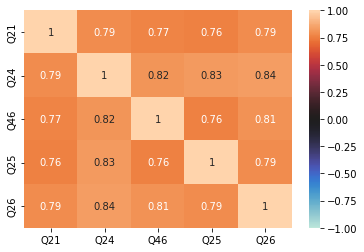

In [34]:
sns.heatmap(matrix, annot=True, vmax = 1, vmin = -1, center = 0)
plt.show()

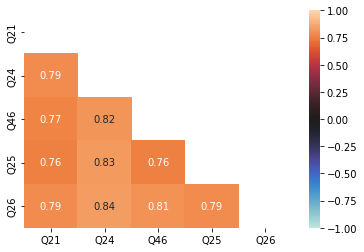

In [35]:
mask = np.triu(np.ones_like(matrix, dtype = bool))
sns.heatmap(matrix, annot=True, vmax = 1, vmin = -1, center = 0, mask = mask)
plt.show()

# **Topic Modeling**

In [ ]:
df2 = df[df['Q19'].notna()]

In [ ]:
import sklearn
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer(analyzer='word',       
                             # min_df=20,                      
                             stop_words='english',             
                             lowercase=True,                  
                             token_pattern='[a-zA-Z0-9]{3,}',  
                             max_features=200,  
                            )

data_vectorized = vectorizer.fit_transform(df2['Q19'])

lda_model_ = LatentDirichletAllocation(n_components=5,
                                      learning_method='online',
                                      random_state=100,       
                                      n_jobs = -1  
                                     )
lda_output = lda_model_.fit_transform(data_vectorized)

print(lda_model_)

In [ ]:
df2.columns

In [ ]:
lda_output = lda_model_.transform(data_vectorized)
topicnames = ["Topic" + str(i) for i in range(5)]
docnames = df2['ResponseId']
df_document_topic = pd.DataFrame(np.round(lda_output, 5), columns=topicnames, index=docnames)
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

In [ ]:
df_document_topic

In [ ]:
# Show top 20 keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model_, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model_, n_words=20)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

December 20 meeting todos:
1. Highly discussed topics
2. Bigram/trigram words as a keyword
3. Emotionality -> common sentiment analysis in relation to topics they discussed -> lexMo & liwc (https://lit.eecs.umich.edu/geoliwc/liwc_dictionary.html)


## **Bigrams & Trigams**

In [40]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

data_words = list(sent_to_words(df2['Q19']))

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=30) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=30)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [55]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[doc] for doc in texts]

def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]
  

In [56]:
data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)
data_words_trigrams = make_trigrams(data_words_nostops)

In [58]:
c_vec = CountVectorizer(stop_words=stopwords, ngram_range=(2,3))
ngrams = c_vec.fit_transform(df2['Q19'])
count_values = ngrams.toarray().sum(axis=0)
vocab = c_vec.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})

In [61]:
df_ngram['polarity'] = df_ngram['bigram/trigram'].apply(lambda x: TextBlob(x).polarity)
df_ngram['subjective'] = df_ngram['bigram/trigram'].apply(lambda x: TextBlob(x).subjectivity)

In [62]:
df_ngram

,frequency,bigram/trigram,polarity,subjective
0,66,data capture,0.0,0.000
1,65,capture platform,0.0,0.000
2,63,data capture platform,0.0,0.000
3,35,real time,0.2,0.300
4,14,purpose platform,0.0,0.000
...,...,...,...,...
5293,1,able capture audio,0.5,0.625
5294,1,ability use keywords,0.0,0.000
5295,1,ability use,0.0,0.000
5296,1,ability understanding conversations,0.0,0.000


In [69]:
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords, ngram_range=(2,3))
lda2 = LatentDirichletAllocation(n_components=3,
                                learning_method='online',
                                random_state=50,       
                                n_jobs = -1)
pipe = make_pipeline(tfidf_vectorizer, lda2)
pipe.fit(df2['Q19'])

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += ", ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
print_top_words(lda2, tfidf_vectorizer.get_feature_names(), n_top_words=3)

Topic #0: data capture, capture platform, data capture platform
Topic #1: real time, emotional tone, talking transcript
Topic #2: data capture, data capture platform, capture platform



# **Contextualized Topic Modeling**

In [ ]:
!pip install contextualized-topic-models==1.8.2
!pip install nltk

In [ ]:
import nltk
nltk.download('stopwords')
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessing

all_text = df2.Q19.str.cat(sep = ' ')
doc = nlp(string(all_text))
sp = WhiteSpacePreprocessing(doc, stopwords_language='english') 

In [ ]:
string(all_text)

In [ ]:
preprocessed_documents, unpreprocessed_corpus, vocab, retained_indices = sp.preprocess()